# Análise de Agrupamento (Clustering)

### Carregamento e Seleção de Dados

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px

In [4]:

path_to_the_truth = r"../dados/microdados_enem_2019/dados_enem_processados.csv.zip"

df = pd.read_csv(path_to_the_truth, sep=",", encoding="utf-8", compression="zip")

cols_clustering = ['MEDIA_CANDIDATO', 'RENDA', 'SCORE_CONSUMO', 'SCORE_CULT_PAIS', 'TP_SEXO', 'TP_ESCOLA']

df = df[cols_clustering].copy()
sample = df.sample(2000, random_state=69)

### Pré-processamento e Normalização

In [5]:
scaler = StandardScaler()
sample_scaled= scaler.fit_transform(pd.get_dummies(sample, drop_first=True))

### Execução do Algoritmo K-Means

Para interpretar os grupos formados, realizamos uma agregação dos dados calculando a média das variáveis numéricas e a moda das variáveis categóricas para cada cluster. Além disso, calculamos a representatividade percentual de cada grupo em relação ao total da amostra. Isso nos permite identificar, por exemplo, quais grupos possuem maior vulnerabilidade socioeconômica ou melhor desempenho acadêmico, transformando os rótulos numéricos do algoritmo em perfis interpretáveis para a tomada de decisão ou estudo estatístico.

In [6]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=69, n_init=10)
sample['cluster'] = kmeans.fit_predict(sample_scaled)

### Visualização em Tabela

In [7]:
perfil_clusters = sample.groupby('cluster').agg({
    'MEDIA_CANDIDATO': 'mean',
    'RENDA': 'mean',
    'SCORE_CONSUMO': 'mean',
    'SCORE_CULT_PAIS': 'mean',
    'TP_SEXO': lambda x: x.mode()[0],  
    'TP_ESCOLA': lambda x: x.mode()[0]
}).reset_index()


contagem = sample['cluster'].value_counts(normalize=True) * 100
perfil_clusters['representatividade_%'] = perfil_clusters['cluster'].map(contagem)

print("Descrição dos clusters (médias Reais):")
display(perfil_clusters)

Descrição dos clusters (médias Reais):


,cluster,MEDIA_CANDIDATO,RENDA,SCORE_CONSUMO,SCORE_CULT_PAIS,TP_SEXO,TP_ESCOLA,representatividade_%
0,0,519.559658,1976.522111,13.748930,5.329529,0,2,35.05
1,1,604.994227,4137.149485,22.103093,9.567010,1,3,9.70
2,2,510.314729,1620.010020,12.558116,4.769539,1,2,49.90
3,3,654.891776,17444.981308,40.542056,12.626168,1,3,5.35


### Visualização 3D

In [8]:
perfil_real = sample.groupby('cluster').agg({
    'RENDA': 'mean',
    'SCORE_CULT_PAIS': 'mean',
    'MEDIA_CANDIDATO': 'mean',
    'SCORE_CONSUMO': 'mean'
}).reset_index()


texto_legendas = "<b>RESUMO DOS PERFIS (Médias Reais)</b><br><br>"
for i, row in perfil_real.iterrows():
    texto_legendas += (
        f"<b>Cluster {int(row['cluster'])}:</b><br>"
        f"• Nota: {row['MEDIA_CANDIDATO']:.1f} pts<br>"
        f"• Renda: R$ {row['RENDA']:.2f}<br>"
        f"• Cap. Cultural: {row['SCORE_CULT_PAIS']:.1f}<br>"
        f"• Consumo: {row['SCORE_CONSUMO']:.1f}<br><br>"
    )


scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
cols_viz = ['RENDA', 'SCORE_CULT_PAIS', 'MEDIA_CANDIDATO']

df_viz = pd.DataFrame(
    scaler_minmax.fit_transform(sample[cols_viz]), 
    columns=cols_viz, 
    index=sample.index
)
df_viz['cluster'] = sample['cluster'].astype(str)


fig = px.scatter_3d(
    df_viz, x='RENDA', y='SCORE_CULT_PAIS', z='MEDIA_CANDIDATO',
    color='cluster',
    title='Mapa de Clusters Socioeducacionais (Escala -1 a 1)',
    labels={'RENDA': 'Eixo Renda', 'SCORE_CULT_PAIS': 'Eixo Cultura', 'MEDIA_CANDIDATO': 'Eixo Nota'},
    color_discrete_sequence=px.colors.qualitative.Dark24,
    opacity=0.7
)


fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1.1, 1.1]),
        yaxis=dict(range=[-1.1, 1.1]),
        zaxis=dict(range=[-1.1, 1.1])
    ),
    margin=dict(r=250, l=0, b=0, t=50), 
    annotations=[
        dict(
            text=texto_legendas,
            align='left',
            showarrow=False,
            xref='paper', yref='paper',
            x=1.15, y=0.5, 
            bordercolor='black', borderwidth=1,
            bgcolor='white', opacity=0.8
        )
    ]
)

fig.update_traces(marker=dict(size=4))
fig.show()

**Observação:** Para o formato PDF não será possível visualizar ou interagir o gráfico 3D gerado pelo Plotly, porém, abaixo temos imagens do gráfico em diferentes rotações

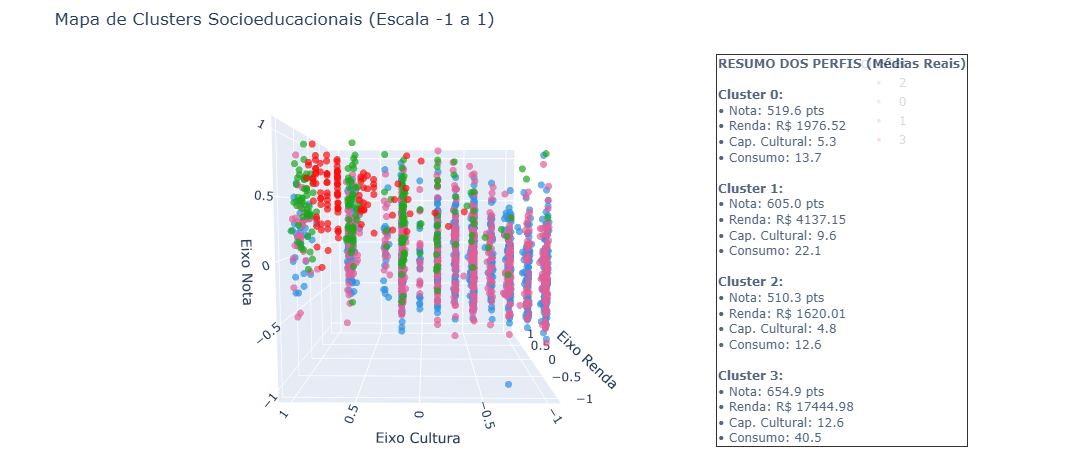

In [ ]:
from IPython.display import Image
Image('../images/plot1.png')

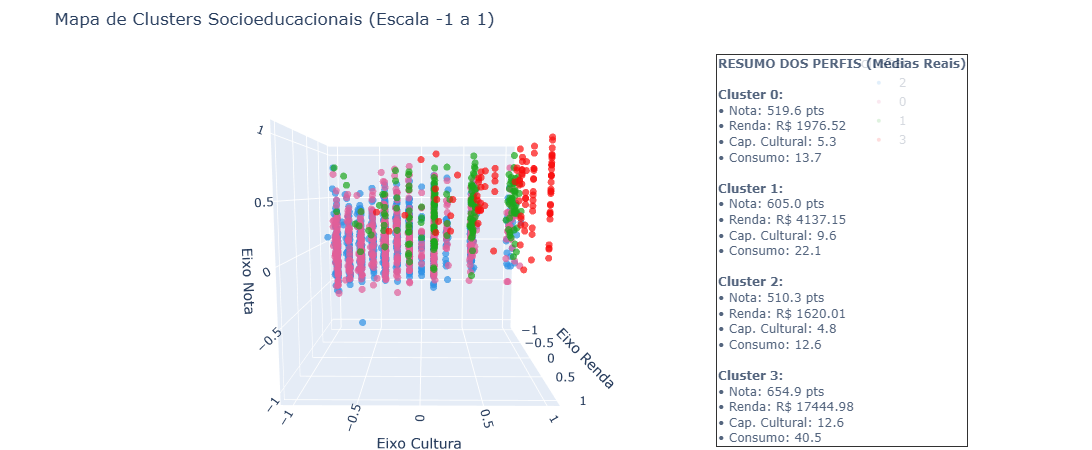

In [ ]:
Image('../images/plot2.png')

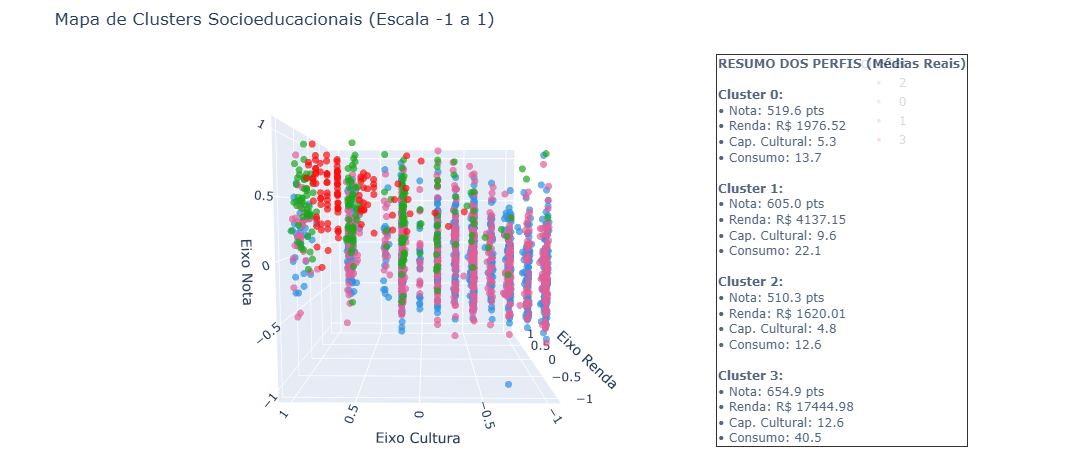

In [15]:
Image('../images/plot3.png')

No PCA em 3D há pouca diferenciação entre os cluster de 0 a 2. Isto implica que devemos levar em consideração outra dimensão, dentre as variáveis disponíveis,  para podermos ver a separação -- o que infelizmente, devido à sina da Intuição Pura do Espaço, não podemos visualizar. 